## U-Net Implementation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

%cd /content/drive/MyDrive/fhms/fetal_ultrasound_head

!mkdir training_images
!mkdir annotated_training_images


/content/drive/MyDrive/fhms/fetal_ultrasound_head


In [ ]:
import shutil
import os


%cd /content/drive/MyDrive/fhms/fetal_ultrasound_head/training_set/training_set
for filename in os.listdir():
    if filename.endswith('.jpg') or filename.endswith('.png'):
        if 'Annotation' in filename:
            shutil.copy(filename, '/content/drive/MyDrive/fhms/fetal_ultrasound_head/annotated_training_images')
        else:
            shutil.copy(filename, '/content/drive/MyDrive/fhms/fetal_ultrasound_head/training_images')


/content/drive/MyDrive/fhms/fetal_ultrasound_head/training_set/training_set


## Masking Contours

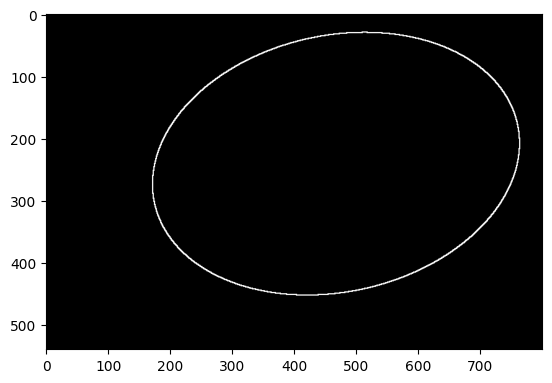

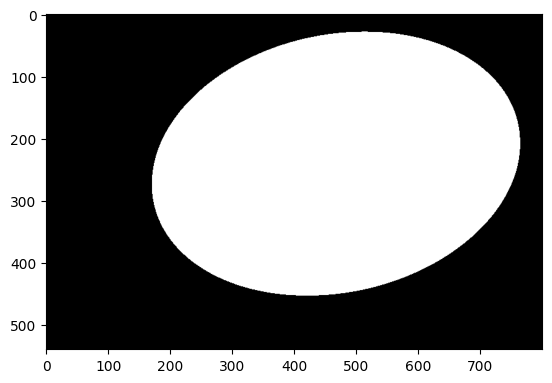

In [ ]:
import cv2
mask1 = cv2.imread("/content/drive/MyDrive/fhms/fetal_ultrasound_head/annotated_training_images/807_HC_Annotation.png",0)

mask = cv2.imread("/content/drive/MyDrive/fhms/fetal_ultrasound_head/annotated_training_images/807_HC_Annotation.png",0)
mask_contour= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_img = cv2.drawContours(mask,mask_contour[0],0,255, -1)



img = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
# Show the image
plt.imshow(img)
plt.show()

img1 = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()


number of images: 999
number of annotations: 999


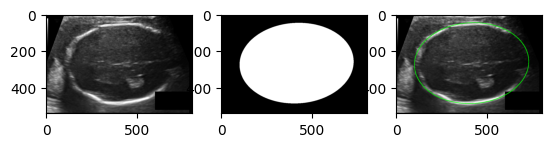

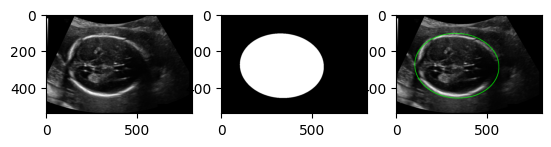

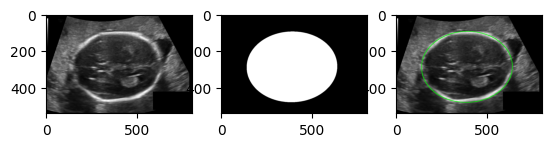

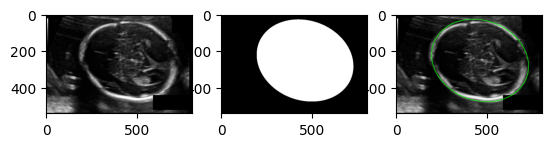

In [ ]:
import os
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import numpy as np

path2train="/content/drive/MyDrive/fhms/fetal_ultrasound_head/training_set/training_set"
path2annts="/content/drive/MyDrive/fhms/fetal_ultrasound_head/training_set/training_set"

imgsList = [pp for pp in os.listdir(path2train) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
anntsList=[pp for pp in os.listdir(path2annts) if "Annotation" in pp]
print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList))

#getting images based on seed number to get consistent results
np.random.seed(7543)
rndImgs=np.random.choice(imgsList,4)
rndImgs

#making image masks and putting them corresponding masks
def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)


    img_mask=mark_boundaries(np.array(img),
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)

#img with masks
for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt= path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")

    plt.subplot(1, 3, 3)
    show_img_mask(img, mask)

## Adding padding to images to make them square shaped - 812*812
## U-Net works with a certain image size only, becuase of its architecture

torch.Size([1, 812, 812])


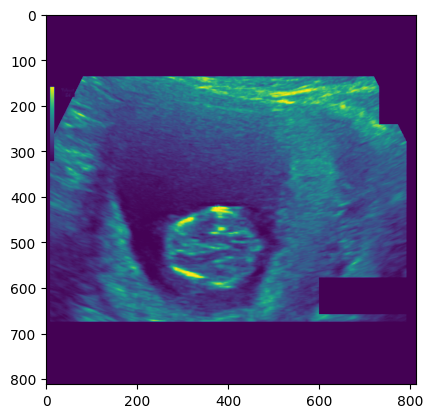

In [ ]:
import numpy as np
from PIL import Image
from torchvision.io import read_image
import torch
import matplotlib.pyplot as plt

def pad_image_to_square(img):


  channels, height, width = img.size()
  diff = abs(812-width)
  # Determine the amount of padding to add on each side
  padding = diff // 2

  # to make it 812*812
  img = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)
  # print(img.shape)

  # print("hey" , img.size())

  channels, height, width = img.size()
  diff = abs(height-width)
  # Determine the amount of padding to add on each side
  padding = diff // 2


  # Pad the tensor with zeros along the height and width dimensions
  if height < width:
      padded_image = torch.nn.functional.pad(img, (0, 0, padding, diff - padding), mode='constant', value=0)
  else:
      padded_image = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)


  return padded_image


# Open the rectangular image
img = read_image('/content/drive/MyDrive/fhms/fetal_ultrasound_head/training_images/100_2HC.png')


# Pad the image to make it square
padded_img = pad_image_to_square(img)
print(padded_img.shape)

tensor_image = padded_img.permute(1, 2, 0)
plt.imshow(tensor_image)
plt.show()


## Creating DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import pandas as pd
from torchvision.io import read_image


class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform , target_transform):
        self.img_path = img_path
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img = pad_image_to_square(img)

        if self.target_path:
          img_path_tar = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])

          target = cv2.imread(img_path_tar , 0)
          mask_contour= cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cv2.drawContours(target,mask_contour[0],0,255, -1)
          target = target[np.newaxis, :, :]
          target = torch.from_numpy(target)
          target = pad_image_to_square(target)
        else :
          target = torch.tensor([])


        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            # print("target", target.shape, type(target))
            target = self.target_transform(target)
            target = torch.where(target > 128, torch.tensor([1.0]), torch.tensor([0.0]))

        return img.float(), target.float()



# Define the transformation to resize the images to 64x64 pixels
transform = transforms.Compose([
    transforms.Resize((252, 252))   # 572 , 572
    # transforms.ToTensor()
])

transform1 = transforms.Compose([
    transforms.Resize((68, 68))   # 388 , 388'

])
# Instantiate dataset object
dataset = CustomDataset(

    img_path = '/content/drive/MyDrive/fhms/fetal_ultrasound_head/training_images' ,
    target_path = '/content/drive/MyDrive/fhms/fetal_ultrasound_head/annotated_training_images' ,
    transform=transform ,
    target_transform = transform1 )

test_dataset = CustomDataset(
    img_path = '/content/drive/MyDrive/fhms/fetal_ultrasound_head/test_set/test_set' ,
    target_path = None ,
    transform=transform ,
    target_transform = None
    )

# justto check number of images
img_path = '/content/drive/MyDrive/fhms/fetal_ultrasound_head/training_images'
print(len(os.listdir(img_path)))
target_path = '/content/drive/MyDrive/fhms/fetal_ultrasound_head/annotated_training_images'
print(len(os.listdir(target_path)))


import torch.utils.data as data
train_dataset, val_dataset = data.random_split(dataset, [799, 200])


# Create train and validation dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True) #,worker_init_fn=lambda _: random.seed(42))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False) #,worker_init_fn=lambda _: random.seed(42))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False) #,worker_init_fn=lambda _: random.seed(42))



999
999


### Showing some of the images from the dataset

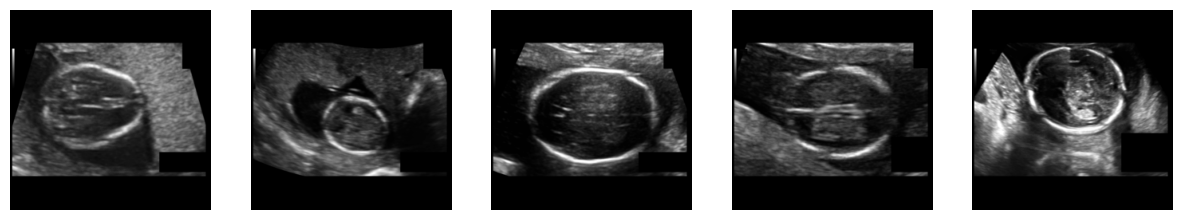

In [ ]:
import matplotlib.pyplot as plt
import torch
i = 0
import itertools
for i, batch in enumerate(train_dataloader):
  if i == 1:
      break

  # Plot each image in a separate subplot
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(5):
      axs[i].imshow(batch[0][i, 0], cmap='gray')
      axs[i].axis('off')
  plt.show()
  i+=1

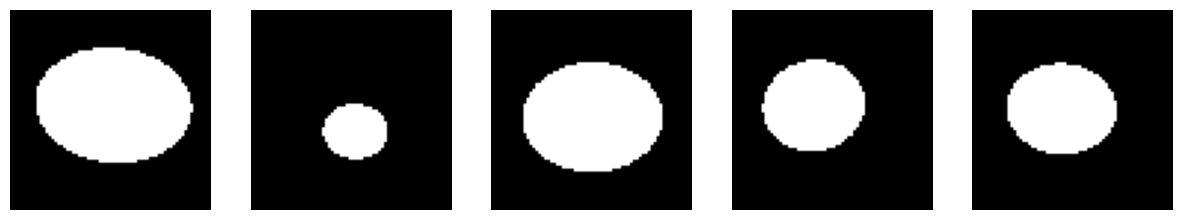

In [ ]:
import matplotlib.pyplot as plt
import torch
i = 0
import itertools
for i, batch in enumerate(train_dataloader):
  if i == 1:
      break
  # print(f"Batch {i+1}: {batch}")

  # Plot each image in a separate subplot
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(5):
      axs[i].imshow(batch[1][i, 0], cmap='gray')
      axs[i].axis('off')
  plt.show()
  i+=1

## Defining U-Net Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def scale_tensor(image ,new_height , new_width):
  scaled_image = F.interpolate(image, size=(new_height, new_width), mode='bilinear', align_corners=True)
  return scaled_image


#double 3x3 convolution
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.Conv2d(in_channel, out_channel, kernel_size=3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
    )
    return conv


# crop the image(tensor) to equal size
# as shown in architecture image , half left side image is concated with right side image
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2

    return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

def out_layer(in_channel , out_channel):
  conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1),
      nn.BatchNorm2d(out_channel),
      nn.Sigmoid()
  )
  return conv_layer

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        # Left side (contracting path)
        self.dwn_conv1 = dual_conv(1, 64)
        self.dwn_conv2 = dual_conv(64, 128)
        self.dwn_conv3 = dual_conv(128, 256)
        self.dwn_conv4 = dual_conv(256, 512)
        self.dwn_conv5 = dual_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Right side  (expnsion path)
        #transpose convolution is used showna as green arrow in architecture image
        self.conv_bn=nn.BatchNorm2d(1024)

        self.trans1 = nn.ConvTranspose2d(1024,512, kernel_size=2, stride= 2)
        self.up_conv1 = dual_conv(1024,512)
        self.trans2 = nn.ConvTranspose2d(512,256, kernel_size=2, stride= 2)
        self.up_conv2 = dual_conv(512,256)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride= 2)
        self.up_conv3 = dual_conv(256,128)
        self.trans4 = nn.ConvTranspose2d(128,64, kernel_size=2, stride= 2)
        self.up_conv4 = dual_conv(128,64)

        #output layer
        # self.out = nn.Conv2d(64, 1, kernel_size=1)
        self.out = out_layer(64 , 1)

    def forward(self, image):

        #Padding the image to make it sqare
        # image = pad_image_to_square(image)
        #forward pass for Left side

        x1 = self.dwn_conv1(image)
        x2 = self.maxpool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.dwn_conv5(x8)


        #forward pass for Right side
        x_norm = self.conv_bn(x9)
        x = self.trans1(x_norm)
        y = crop_tensor(x, x7)
        # print(x.shape , y.shape)
        x = self.up_conv1(torch.cat([x,y], 1))

        x = self.trans2(x)
        y = crop_tensor(x, x5)
        x = self.up_conv2(torch.cat([x,y], 1))

        x = self.trans3(x)
        y = crop_tensor(x, x3)
        x = self.up_conv3(torch.cat([x,y], 1))

        x = self.trans4(x)
        y = crop_tensor(x, x1)
        x = self.up_conv4(torch.cat([x,y], 1))

        x = self.out(x)


        return x



In [ ]:
!pip install torchsummary

In [ ]:
params_model = {
    "input_shape": (1, 572, 572),    # Input shape: 1 channel (grayscale), height and width
    "initial_filters": 64,           # Filters in the first convolutional layer
    "num_classes": 1,                # Number of output channels, typically 1 for binary segmentation
    "use_batch_norm": True,          # Batch normalization is used
    "use_transposed_conv": True,     # Transposed convolutions are used for upsampling
    "output_activation": "sigmoid"   # Sigmoid activation in the output layer for binary segmentation
}



In [ ]:
# Initialize your U-Net model with params_model
model = Unet()

# Print a summary of the model (if using torchsummary)
from torchsummary import summary
summary(model, input_size=params_model["input_shape"])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 572, 572]               2
            Conv2d-2         [-1, 64, 570, 570]             640
       BatchNorm2d-3         [-1, 64, 570, 570]             128
              ReLU-4         [-1, 64, 570, 570]               0
            Conv2d-5         [-1, 64, 568, 568]          36,928
       BatchNorm2d-6         [-1, 64, 568, 568]             128
              ReLU-7         [-1, 64, 568, 568]               0
         MaxPool2d-8         [-1, 64, 284, 284]               0
       BatchNorm2d-9         [-1, 64, 284, 284]             128
           Conv2d-10        [-1, 128, 282, 282]          73,856
      BatchNorm2d-11        [-1, 128, 282, 282]             256
             ReLU-12        [-1, 128, 282, 282]               0
           Conv2d-13        [-1, 128, 280, 280]         147,584
      BatchNorm2d-14        [-1, 128, 2

In [ ]:
# Enable GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training U-Net

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from dataset import MyDataset
# from model import UNet

torch.cuda.empty_cache()

import gc
# del inputs , targets , model
gc.collect()



# Define hyperparameters
# batch_size = 2
learning_rate = 0.001
num_epochs = 25



# Define the U-Net architecture
model = Unet()
if torch.cuda.is_available():
  model.cuda()

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

v_loss , train_loss = [] , []
# Train the U-Net
for epoch in range(num_epochs):
  model.train()
  start_time = time.time()
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):
      # Forward pass
      inputs = inputs.to(device)   #
      targets = targets.to(device)#

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = 0
    for inputs, targets in val_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        val_loss += criterion(outputs, targets)
    val_loss /= len(val_dataloader)
  v_loss.append(val_loss.item())
  train_loss.append(loss.item())
  end_time = time.time()
  epoch_duration = end_time - start_time
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}  , Val Loss: {val_loss.item():.4f}, Time: {epoch_duration:.2f}s")

# Save the trained model
# torch.save(model.state_dict(), 'path/to/trained/model')


Epoch [1/25], Train Loss: 0.8109  , Val Loss: 0.8145, Time: 154.87s
Epoch [2/25], Train Loss: 0.8069  , Val Loss: 0.7937, Time: 163.90s
Epoch [3/25], Train Loss: 0.7751  , Val Loss: 0.7905, Time: 156.38s
Epoch [4/25], Train Loss: 0.7617  , Val Loss: 0.7845, Time: 151.74s
Epoch [5/25], Train Loss: 0.7654  , Val Loss: 0.7658, Time: 162.05s
Epoch [6/25], Train Loss: 0.7443  , Val Loss: 0.7519, Time: 151.89s
Epoch [7/25], Train Loss: 0.7325  , Val Loss: 0.7497, Time: 152.81s
Epoch [8/25], Train Loss: 0.7601  , Val Loss: 0.7423, Time: 153.90s
Epoch [9/25], Train Loss: 0.7414  , Val Loss: 0.7397, Time: 161.59s
Epoch [10/25], Train Loss: 0.7222  , Val Loss: 0.7300, Time: 151.92s
Epoch [11/25], Train Loss: 0.7282  , Val Loss: 0.7224, Time: 152.64s
Epoch [12/25], Train Loss: 0.7292  , Val Loss: 0.7257, Time: 153.10s
Epoch [13/25], Train Loss: 0.7311  , Val Loss: 0.7122, Time: 161.23s
Epoch [14/25], Train Loss: 0.6977  , Val Loss: 0.7179, Time: 152.29s
Epoch [15/25], Train Loss: 0.6858  , Val Lo

### 3. DICE Score on Validation Set

In [ ]:
def dice_coefficient(y_pred, y_true):
    smooth = 0.001
    y_pred = y_pred.view(-1)
    # print(type(y_pred), y_pred.shape)
    y_true = y_true.view(-1)
    intersection = torch.sum(y_pred * y_true)
    dice = (2.0 * intersection + smooth) / (torch.sum(y_pred) + torch.sum(y_true) + smooth)
    return dice

def dice_score(y_pred_batch, y_true_batch):
    dice_scores = torch.zeros(y_pred_batch.shape[0])
    for i in range(y_pred_batch.shape[0]):
        dice_scores[i] = dice_coefficient(y_pred_batch[i], y_true_batch[i])
    return dice_scores

with torch.no_grad():
  dice_com = torch.tensor([])
  model.to(device)
  model.eval()
  val_loss = 0
  for inputs, targets in val_dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)#

      outputs = model(inputs)
      outputs = torch.where(outputs > 0.5, torch.tensor([1.0]).to(device), torch.tensor([0.0]).to(device))
      dice = dice_score(outputs, targets)
      dice_com = torch.cat((dice_com, dice))

print("Dice Score of Validation Set")
dice_com.mean().item()

Dice Score of Validation Set


0.8666491508483887

## DICE score - 0.8772185(25-10-2024), 0.866649(2-11-2024)

## 4. Validation and Training loss plot

Text(0, 0.5, 'Loss')

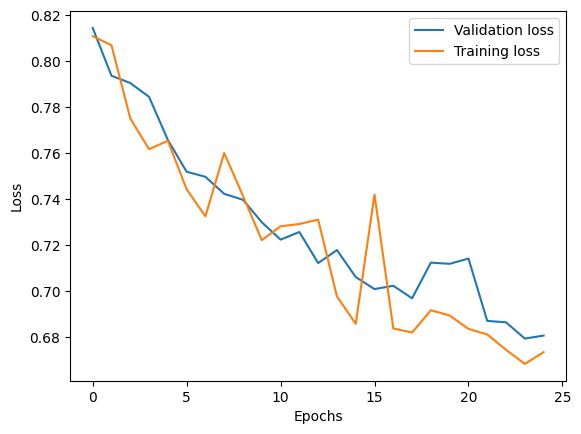

In [ ]:
import matplotlib.pyplot as plt
plt.plot(v_loss)
plt.plot(train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/fhms/model2-2-11.pt')
# model.load_state_dict(torch.load(model_path))

In [ ]:
# model = Unet()
# if torch.cuda.is_available():
#   model.cuda()
# model.load_state_dict(torch.load('/content/drive/MyDrive/ML-Assign-6/model.pt'))

<All keys matched successfully>

In [ ]:
import torch
torch.cuda.empty_cache()
# del model
import gc
gc.collect()

35

## Prediction on test set

In [ ]:
import itertools
# Get the first 2 batches
top_2_batches = list(itertools.islice(test_dataloader, 2))

out = []
test = []
test1 = []
# Process the batches
with torch.no_grad():
  for batch in top_2_batches:
      # Do something with the batch

      inputs = batch[0].to(device)   #

      test.append(inputs)
      test1.append(batch[1].to(device))

      outputs = model(inputs)
      out.append(outputs)

      torch.cuda.empty_cache()
      gc.collect()
      print(batch[0].shape)


torch.Size([16, 1, 252, 252])
torch.Size([16, 1, 252, 252])


## Some Prediction on Test Set



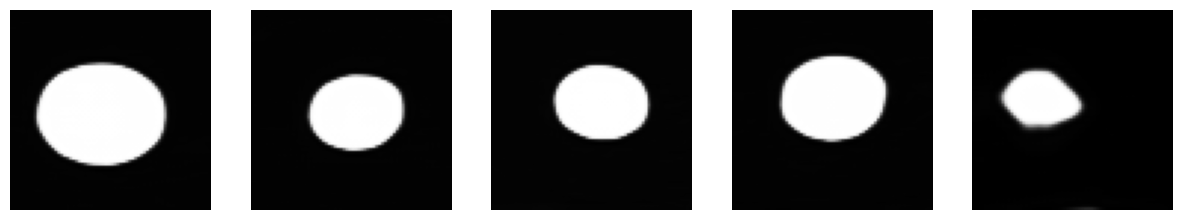

In [ ]:
import matplotlib.pyplot as plt
import torch

# Create a tensor of size [5, 1, 628, 628] (replace with your own tensor)
tensor = out[1].cpu().detach().numpy()

# Plot each image in a separate subplot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(tensor[i, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

### Corresponding Images

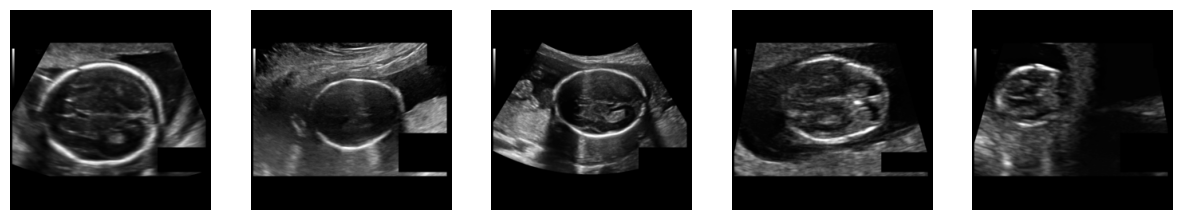

In [ ]:
import matplotlib.pyplot as plt
import torch

# Create a tensor of size [5, 1, 628, 628] (replace with your own tensor)
tensor_train = test[1].cpu().detach().numpy()

# Plot each image in a separate subplot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(tensor_train[i, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

### Some Compiled results

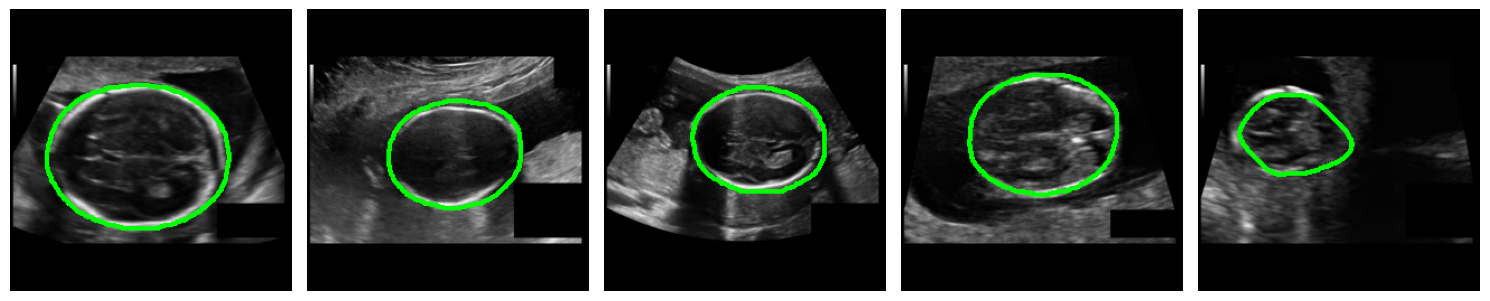

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_pil_image, resize

def visualize_ultrasound_boundaries(ultrasound_tensor, mask_tensor, num_samples=5, figsize=(15, 5)):
    """
    Visualize ultrasound images with mask boundaries using skimage's mark_boundaries.
    Handles different sizes by resizing masks to match ultrasound images.

    Args:
        ultrasound_tensor: Tensor containing ultrasound images [N, 1, H, W]
        mask_tensor: Tensor containing binary masks [N, 1, H, W]
        num_samples: Number of samples to display
        figsize: Figure size for the plot
    """
    # Create figure
    fig, axs = plt.subplots(nrows=1, ncols=num_samples, figsize=figsize)

    for i in range(num_samples):
        # Get current image and mask
        img = ultrasound_tensor[i, 0].cpu().detach()
        mask = mask_tensor[i, 0].cpu().detach()

        # Get ultrasound image dimensions
        us_height, us_width = img.shape

        # Resize mask to match ultrasound image dimensions
        mask = resize(mask.unsqueeze(0), size=[us_height, us_width], antialias=True).squeeze(0)

        # Convert to numpy and normalize
        img = img.numpy()
        mask = mask.numpy()

        # Normalize image to [0, 1] range if needed
        if img.max() > 1:
            img = img / 255.0

        # Ensure mask is binary
        mask = (mask > 0.5).astype(bool)

        # Create mask boundary overlay
        img_mask = mark_boundaries(
            img,
            mask,
            outline_color=(0, 1, 0),  # Green outline
            color=(0, 1, 0),          # Green fill
            mode='thick'              # Makes the boundary more visible
        )

        # Display the result
        axs[i].imshow(img_mask)
        axs[i].axis('off')

    plt.tight_layout()
    return fig


fig = visualize_ultrasound_boundaries(test[1], out[1])
plt.show()

# Optional: Function to show a single image
def show_single_boundary(img, mask):
    """
    Display a single ultrasound image with mask boundary.
    Handles different sizes by resizing mask to match ultrasound image.

    Args:
        img: Single ultrasound image tensor [1, H, W]
        mask: Single mask tensor [1, H, W]
    """
    if torch.is_tensor(img):
        img = img.cpu().detach()
        mask = mask.cpu().detach()

    # Get ultrasound image dimensions
    us_height, us_width = img[0].shape

    # Resize mask to match ultrasound image dimensions
    mask = resize(mask, size=[us_height, us_width], antialias=True)

    # Convert to numpy
    img = img.numpy()
    mask = mask.numpy()

    # Normalize image if needed
    if img.max() > 1:
        img = img / 255.0

    # Ensure mask is binary
    mask = (mask[0] > 0.5).astype(bool)

    # Create mask boundary overlay
    img_mask = mark_boundaries(
        img[0],
        mask,
        outline_color=(0, 1, 0),
        color=(0, 1, 0),
        mode='thick'
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(img_mask)
    plt.axis('off')
    plt.show()

# Example usage for single image
# show_single_boundary(test[0][0], out[0][0])  # Show first image from batch